<a href="https://colab.research.google.com/github/pbenito1/TFM/blob/main/2_ML_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import re
import os
from collections import Counter
import pandas as pd
from math import log
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import ensemble
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score

# Clasificadores

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV



%matplotlib inline

In [2]:
def custom_cm(cf_matrix):
  # Ref: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
  group_names = ['TN','FP','FN','TP']
  group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [3]:
# Cargamos datos
DATASET_PATH='/content/drive/MyDrive/TFM/data_processed/dga.csv'
df = pd.read_csv(DATASET_PATH,index_col=0)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df.sample(10)

,domain,family,category,tld,sld,subdomains_number,digits,length,num_dashes,entropy,ratio_vc
573441,skimresources.com,NaN,benign,com,skimresources,3,0,13,0,3.026987,0.625000
550056,doudouf.ch,tofsee,malign,ch,doudouf,3,0,7,0,1.950212,1.333333
1003828,cbmm.org,NaN,benign,org,cbmm,3,0,4,0,1.500000,0.000000
243874,heardwomen.net,suppobox,malign,net,heardwomen,3,0,10,0,3.121928,0.666667
391082,ev7n3lahpmy4165bws.com,rovnix,malign,com,ev7n3lahpmy4165bws,3,6,18,0,4.169925,0.125000
496226,powerkissshock.com,matsnu,malign,com,powerkissshock,3,0,14,0,3.182006,0.400000
810377,259zb.com,NaN,benign,com,259zb,3,3,5,0,2.321928,0.000000
37846,edy0what7x7hc6cnclap3fw.ws,corebot,malign,ws,edy0what7x7hc6cnclap3fw,3,5,23,0,3.969002,0.150000
523290,skaiyyqqcgqakakq.org,ramdo,malign,org,skaiyyqqcgqakakq,3,0,16,0,2.780639,0.333333
504514,gienelmbgro.net,oderoor,malign,net,gienelmbgro,3,0,11,0,3.095795,0.571429


In [5]:
#df=df.sample(100000)

In [6]:
y = df['category']
X = df.drop(['family','category','domain','tld','sld'], axis=1)

In [7]:
df.family = df.family.fillna('benign')

In [8]:
# sampleo estratificado por familia. Importante, dado que hay familias con pocas muestras.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['family'])

# Random Forest

In [9]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [10]:
print("El accuracy del modelo Random Forest es:",rf.score(X_test, y_test))

El accuracy del modelo Random Forest es: 0.8220631225164984


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


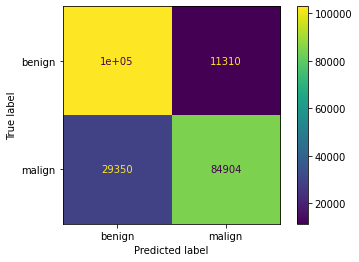

In [11]:
plot_confusion_matrix(rf, X_test, y_test)

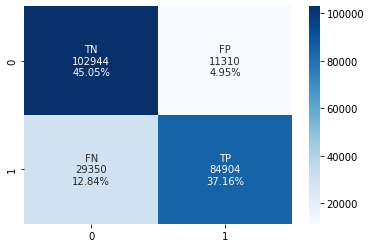

In [12]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)
custom_cm(cf_matrix)